In [1]:
import os

DATASET_DIR = r"C:\Preet\clean_paired_bscans"

low_set = set()
high_set = set()

for file in os.listdir(DATASET_DIR):
    if file.endswith("_l.png"):
        low_set.add(file.replace("_l.png", ""))
    elif file.endswith("_h.png"):
        high_set.add(file.replace("_h.png", ""))

# Find mismatches
missing_high = low_set - high_set
missing_low  = high_set - low_set

print(f"Total *_l.png: {len(low_set)}")
print(f"Total *_h.png: {len(high_set)}")
print(f"Total valid pairs: {len(low_set & high_set)}")

if missing_high:
    print("\n❌ These have *_l.png but missing *_h.png:")
    for name in sorted(missing_high):
        print(f"  {name}_l.png")

if missing_low:
    print("\n❌ These have *_h.png but missing *_l.png:")
    for name in sorted(missing_low):
        print(f"  {name}_h.png")

if not missing_high and not missing_low:
    print("\n✅ All images are correctly paired!")


Total *_l.png: 8300
Total *_h.png: 8300
Total valid pairs: 8300

✅ All images are correctly paired!


Unet with 3 encoding - decoding layers and attention gates in skip connections and 6 residual blocks in bottleneck

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# ==========================
# CONFIG
# ==========================
DATASET_DIR = r"C:\Preet\9000_paired_bscans"  # both *_l.png and *_h.png are here
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 75
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

MODEL_PATH = os.path.join(DATASET_DIR, "best_attention_unet_final.pth")
RESULTS_DIR = os.path.join(DATASET_DIR, "predictions_attention_final")
os.makedirs(RESULTS_DIR, exist_ok=True)

# ==========================
# DATASET
# ==========================
class GPRDataset(Dataset):
    def __init__(self, x_paths, y_paths):
        self.x_paths = x_paths
        self.y_paths = y_paths

    def __len__(self):
        return len(self.x_paths)

    def __getitem__(self, idx):
        x = np.array(Image.open(self.x_paths[idx]).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        y = np.array(Image.open(self.y_paths[idx]).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        x = torch.tensor(x).unsqueeze(0)  # (1,H,W)
        y = torch.tensor(y).unsqueeze(0)
        return x, y

def load_data(dataset_dir):
    low_paths, high_paths = [], []
    for file in os.listdir(dataset_dir):
        if file.endswith("_l.png"):
            low_path = os.path.join(dataset_dir, file)
            high_path = os.path.join(dataset_dir, file.replace("_l.png", "_h.png"))
            if os.path.exists(high_path):
                low_paths.append(low_path)
                high_paths.append(high_path)
    return low_paths, high_paths

all_x, all_y = load_data(DATASET_DIR)

# Split 70/15/15
train_x, temp_x, train_y, temp_y = train_test_split(all_x, all_y, test_size=0.30, random_state=42)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.50, random_state=42)

print(f"Train: {len(train_x)}, Val: {len(val_x)}, Test: {len(test_x)}")

train_loader = DataLoader(GPRDataset(train_x, train_y), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(GPRDataset(val_x, val_y), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(GPRDataset(test_x, test_y), batch_size=1, shuffle=False)

# ==========================
# MODEL BLOCKS
# ==========================
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x):
        return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

# ==========================
# UNet-3 with Attention + Residual Bottleneck
# ==========================
class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (3 levels)
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck with residual blocks (FIX: 256 channels)
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)   # bottleneck=256, skip=256
        self.dec3 = ConvBlock(256+256, 256)        # concat → 512

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(256+128, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(128+64, 64)

        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))

        return self.out_conv(d1)


# ==========================
# TRAINING
# ==========================
model = UNet3WithAttention().to(DEVICE)
criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            val_loss += criterion(preds, y).item() * x.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  ✅ Saved Best Model at Epoch {epoch+1}")

# ==========================
# INFERENCE
# ==========================
print("\nRunning inference on test set...")
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

for i, (x, y) in enumerate(test_loader):
    x = x.to(DEVICE)
    with torch.no_grad():
        pred = model(x).cpu().squeeze(0).squeeze(0).numpy()
    pred_img = (pred * 255.0).clip(0, 255).astype(np.uint8)
    Image.fromarray(pred_img).save(os.path.join(RESULTS_DIR, f"pred_{i+1}.png"))

print(f"Predictions saved in {RESULTS_DIR}")

Running on: cuda
Train: 6300, Val: 1350, Test: 1350
Epoch [1/75] Train Loss: 0.003996, Val Loss: 0.000058
  ✅ Saved Best Model at Epoch 1
Epoch [2/75] Train Loss: 0.000051, Val Loss: 0.000038
  ✅ Saved Best Model at Epoch 2
Epoch [3/75] Train Loss: 0.000037, Val Loss: 0.000029
  ✅ Saved Best Model at Epoch 3
Epoch [4/75] Train Loss: 0.000030, Val Loss: 0.000027
  ✅ Saved Best Model at Epoch 4
Epoch [5/75] Train Loss: 0.000025, Val Loss: 0.000023
  ✅ Saved Best Model at Epoch 5
Epoch [6/75] Train Loss: 0.000026, Val Loss: 0.000019
  ✅ Saved Best Model at Epoch 6
Epoch [7/75] Train Loss: 0.000021, Val Loss: 0.000017
  ✅ Saved Best Model at Epoch 7
Epoch [8/75] Train Loss: 0.000021, Val Loss: 0.000022
Epoch [9/75] Train Loss: 0.000018, Val Loss: 0.000019
Epoch [10/75] Train Loss: 0.000018, Val Loss: 0.000014
  ✅ Saved Best Model at Epoch 10
Epoch [11/75] Train Loss: 0.000017, Val Loss: 0.000013
  ✅ Saved Best Model at Epoch 11
Epoch [12/75] Train Loss: 0.000017, Val Loss: 0.000034
Epoch [

In [4]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from math import log10


import shutil
os.makedirs(r"C:\Preet\9000_paired_bscans\ground_truth_test_final", exist_ok=True)

for f in test_y:  # list of test high-res paths from your train/val/test split
    shutil.copy(f, r"C:\Preet\9000_paired_bscans\ground_truth_test_final")


# ==== PATHS ====
pred_dir = r"C:\Preet\9000_paired_bscans\predictions_attention_final"
gt_dir   = r"C:\Preet\9000_paired_bscans\ground_truth_test_final"

# ==== FUNCTIONS ====
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

# ==== MAIN ====
psnr_values, ssim_values = [], []

pred_files = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
gt_files   = sorted([f for f in os.listdir(gt_dir)   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

num_pairs = min(len(pred_files), len(gt_files))
if num_pairs == 0:
    print("[Error] No matching image files found in both directories.")
else:
    if len(pred_files) != len(gt_files):
        print(f"[Warning] Different number of images: Predictions={len(pred_files)}, Ground Truth={len(gt_files)}")
        print(f"Evaluating only first {num_pairs} matched pairs.")

    for i in range(num_pairs):
        pred_path = os.path.join(pred_dir, pred_files[i])
        gt_path   = os.path.join(gt_dir, gt_files[i])

        pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
        gt_img   = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        if pred_img is None or gt_img is None:
            print(f"[Error] Could not load: {pred_files[i]} or {gt_files[i]}")
            continue

        if pred_img.shape != gt_img.shape:
            pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]))

        psnr_values.append(calculate_psnr(pred_img, gt_img))
        ssim_values.append(calculate_ssim(pred_img, gt_img))

    if psnr_values and ssim_values:
        print(f"\n---- Test Set Evaluation ----")
        print(f"SSIM: avg={np.mean(ssim_values):.4f}, min={np.min(ssim_values):.4f}, max={np.max(ssim_values):.4f}")
        print(f"PSNR: avg={np.mean(psnr_values):.2f} dB, min={np.min(psnr_values):.2f} dB, max={np.max(psnr_values):.2f} dB")


---- Test Set Evaluation ----
SSIM: avg=0.8934, min=0.7024, max=0.9976
PSNR: avg=35.35 dB, min=28.49 dB, max=50.02 dB


In [5]:
import os
import re
import numpy as np
from PIL import Image
import cv2
from math import log10
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn

# =========================
# CONFIG
# =========================
FREQ_DIRS = [
    r"C:\Preet\validation dataset\png_images_650M_1083M",
    r"C:\Preet\validation dataset\png_images_700M_1167M",
    r"C:\Preet\validation dataset\png_images_800M_1333M",
    r"C:\Preet\validation dataset\png_images_850M_1416M",
    r"C:\Preet\validation dataset\png_images_900M_1500M",
]

MODEL_PATH = r"C:\Preet\9000_paired_bscans\best_attention_unet_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (256, 256)

# =========================
# MODEL BLOCKS (UNet3 + 6 RB)
# =========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# =========================
# HELPERS
# =========================
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

def numerical_sort(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', f).group()))

# =========================
# LOAD MODEL
# =========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# =========================
# INFERENCE LOOP
# =========================
for freq_dir in FREQ_DIRS:
    print(f"\n---- Evaluating {os.path.basename(freq_dir)} ----")
    pred_dir = os.path.join(freq_dir, "predictions_attention_unet_final")
    os.makedirs(pred_dir, exist_ok=True)

    low_files = numerical_sort([f for f in os.listdir(freq_dir) if f.endswith("_l.png")])
    high_files = numerical_sort([f for f in os.listdir(freq_dir) if f.endswith("_h.png")])

    psnr_values, ssim_values = [], []

    for i in range(len(low_files)):
        low_path = os.path.join(freq_dir, low_files[i])
        high_path = os.path.join(freq_dir, high_files[i])

        # Load LR
        lr_img = np.array(Image.open(low_path).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        lr_tensor = torch.tensor(lr_img).unsqueeze(0).unsqueeze(0).to(DEVICE)

        # Predict
        with torch.no_grad():
            pred = model(lr_tensor).cpu().numpy()

        # remove batch and channel dims, scale to 0-255
        pred_img = np.squeeze(pred)
        pred_img = (pred_img * 255.0).clip(0, 255).astype(np.uint8)

        # increase contrast (so it's dark like GT)
        pred_img = cv2.normalize(pred_img, None, 0, 255, cv2.NORM_MINMAX)

        # save prediction
        pred_path = os.path.join(pred_dir, f"pred_{i+1}.png")
        Image.fromarray(pred_img).save(pred_path)

        # Load GT
        gt_img = cv2.imread(high_path, cv2.IMREAD_GRAYSCALE)
        if pred_img.shape != gt_img.shape:
            pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]))

        # Metrics
        psnr_values.append(calculate_psnr(pred_img, gt_img))
        ssim_values.append(calculate_ssim(pred_img, gt_img))

    # Results
    if psnr_values and ssim_values:
        print(f"SSIM: avg={np.mean(ssim_values):.4f}, min={np.min(ssim_values):.4f}, max={np.max(ssim_values):.4f}")
        print(f"PSNR: avg={np.mean(psnr_values):.2f} dB, min={np.min(psnr_values):.2f} dB, max={np.max(psnr_values):.2f} dB")
    else:
        print("[Error] No valid pairs processed.")



---- Evaluating png_images_650M_1083M ----
SSIM: avg=0.9527, min=0.9214, max=0.9646
PSNR: avg=33.37 dB, min=30.88 dB, max=34.31 dB

---- Evaluating png_images_700M_1167M ----
SSIM: avg=0.9842, min=0.7585, max=0.9888
PSNR: avg=34.36 dB, min=29.02 dB, max=35.67 dB

---- Evaluating png_images_800M_1333M ----
SSIM: avg=0.9920, min=0.9770, max=0.9957
PSNR: avg=41.58 dB, min=35.33 dB, max=43.37 dB

---- Evaluating png_images_850M_1416M ----
SSIM: avg=0.9597, min=0.9376, max=0.9699
PSNR: avg=33.57 dB, min=31.41 dB, max=34.67 dB

---- Evaluating png_images_900M_1500M ----
SSIM: avg=0.9276, min=0.8818, max=0.9457
PSNR: avg=30.34 dB, min=28.96 dB, max=31.43 dB


In [6]:
import os
import re
import numpy as np
from PIL import Image
import cv2
from math import log10
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn

# =========================
# CONFIG
# =========================
DATASET_DIR = r"C:\Preet\validation dataset\png_images_650M_1083M_1800M"
MODEL_PATH = r"C:\Preet\9000_paired_bscans\best_attention_unet_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (256, 256)

# =========================
# MODEL BLOCKS
# =========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# =========================
# HELPERS
# =========================
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

def numerical_sort(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', f).group()))

def run_model(img, model):
    tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = model(tensor).cpu().numpy()
    pred = np.squeeze(pred)
    pred = (pred * 255.0).clip(0, 255).astype(np.uint8)
    return cv2.normalize(pred, None, 0, 255, cv2.NORM_MINMAX)

# =========================
# LOAD MODEL
# =========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# =========================
# INFERENCE 2-STAGE
# =========================
files_650 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("650_bscan.png")])
files_1083 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("1083_bscan.png")])
files_1800 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("1800_bscan.png")])

psnr_stage1, ssim_stage1 = [], []
psnr_stage2, ssim_stage2 = [], []

pred_dir1 = os.path.join(DATASET_DIR, "predictions_stage1")
pred_dir2 = os.path.join(DATASET_DIR, "predictions_stage2")
os.makedirs(pred_dir1, exist_ok=True)
os.makedirs(pred_dir2, exist_ok=True)

for i in range(len(files_650)):
    # ---- Stage 1: 650 -> pred -> compare with 1083 ----
    lr_img = np.array(Image.open(os.path.join(DATASET_DIR, files_650[i])).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
    gt_1083 = cv2.imread(os.path.join(DATASET_DIR, files_1083[i]), cv2.IMREAD_GRAYSCALE)

    pred_1083 = run_model(lr_img, model)
    Image.fromarray(pred_1083).save(os.path.join(pred_dir1, f"pred1_{i+1}.png"))

    if pred_1083.shape != gt_1083.shape:
        pred_1083 = cv2.resize(pred_1083, (gt_1083.shape[1], gt_1083.shape[0]))

    psnr_stage1.append(calculate_psnr(pred_1083, gt_1083))
    ssim_stage1.append(calculate_ssim(pred_1083, gt_1083))

    # ---- Stage 2: pred_1083 -> pred -> compare with 1800 ----
    gt_1800 = cv2.imread(os.path.join(DATASET_DIR, files_1800[i]), cv2.IMREAD_GRAYSCALE)

    # resize pred_1083 to IMAGE_SIZE before refeeding
    pred_1083_resized = cv2.resize(pred_1083, IMAGE_SIZE).astype(np.float32) / 255.0
    pred_1800 = run_model(pred_1083_resized, model)
    Image.fromarray(pred_1800).save(os.path.join(pred_dir2, f"pred2_{i+1}.png"))

    if pred_1800.shape != gt_1800.shape:
        pred_1800 = cv2.resize(pred_1800, (gt_1800.shape[1], gt_1800.shape[0]))

    psnr_stage2.append(calculate_psnr(pred_1800, gt_1800))
    ssim_stage2.append(calculate_ssim(pred_1800, gt_1800))

# =========================
# RESULTS
# =========================
print("\n---- Stage 1: 650 → pred → compare with 1083 ----")
print(f"SSIM: avg={np.mean(ssim_stage1):.4f}, min={np.min(ssim_stage1):.4f}, max={np.max(ssim_stage1):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage1):.2f} dB, min={np.min(psnr_stage1):.2f} dB, max={np.max(psnr_stage1):.2f} dB")

print("\n---- Stage 2: pred_1083 → pred → compare with 1800 ----")
print(f"SSIM: avg={np.mean(ssim_stage2):.4f}, min={np.min(ssim_stage2):.4f}, max={np.max(ssim_stage2):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage2):.2f} dB, min={np.min(psnr_stage2):.2f} dB, max={np.max(psnr_stage2):.2f} dB")



---- Stage 1: 650 → pred → compare with 1083 ----
SSIM: avg=0.9506, min=0.9237, max=0.9641
PSNR: avg=33.30 dB, min=31.31 dB, max=33.90 dB

---- Stage 2: pred_1083 → pred → compare with 1800 ----
SSIM: avg=0.9216, min=0.8870, max=0.9434
PSNR: avg=28.79 dB, min=28.13 dB, max=29.92 dB


In [2]:
import os
import re
import numpy as np
from PIL import Image
import cv2
from math import log10
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn

# =========================
# CONFIG
# =========================
DATASET_DIR = r"C:\Preet\validation dataset\png_images_900M_1500M_2500M"
MODEL_PATH = r"C:\Preet\9000_paired_bscans\best_attention_unet_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (256, 256)

# =========================
# MODEL BLOCKS
# =========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# =========================
# HELPERS
# =========================
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

def numerical_sort(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', f).group()))

def run_model(img, model):
    tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = model(tensor).cpu().numpy()
    pred = np.squeeze(pred)
    pred = (pred * 255.0).clip(0, 255).astype(np.uint8)
    return cv2.normalize(pred, None, 0, 255, cv2.NORM_MINMAX)

# =========================
# LOAD MODEL
# =========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# =========================
# INFERENCE 2-STAGE
# =========================
files_650 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("900_bscan.png")])
files_1083 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("1500_bscan.png")])
files_1800 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("2500_bscan.png")])

psnr_stage1, ssim_stage1 = [], []
psnr_stage2, ssim_stage2 = [], []

pred_dir1 = os.path.join(DATASET_DIR, "predictions_stage1")
pred_dir2 = os.path.join(DATASET_DIR, "predictions_stage2")
os.makedirs(pred_dir1, exist_ok=True)
os.makedirs(pred_dir2, exist_ok=True)

for i in range(len(files_650)):
    # ---- Stage 1: 650 -> pred -> compare with 1083 ----
    lr_img = np.array(Image.open(os.path.join(DATASET_DIR, files_650[i])).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
    gt_1083 = cv2.imread(os.path.join(DATASET_DIR, files_1083[i]), cv2.IMREAD_GRAYSCALE)

    pred_1083 = run_model(lr_img, model)
    Image.fromarray(pred_1083).save(os.path.join(pred_dir1, f"pred1_{i+1}.png"))

    if pred_1083.shape != gt_1083.shape:
        pred_1083 = cv2.resize(pred_1083, (gt_1083.shape[1], gt_1083.shape[0]))

    psnr_stage1.append(calculate_psnr(pred_1083, gt_1083))
    ssim_stage1.append(calculate_ssim(pred_1083, gt_1083))

    # ---- Stage 2: pred_1083 -> pred -> compare with 1800 ----
    gt_1800 = cv2.imread(os.path.join(DATASET_DIR, files_1800[i]), cv2.IMREAD_GRAYSCALE)

    # resize pred_1083 to IMAGE_SIZE before refeeding
    pred_1083_resized = cv2.resize(pred_1083, IMAGE_SIZE).astype(np.float32) / 255.0
    pred_1800 = run_model(pred_1083_resized, model)
    Image.fromarray(pred_1800).save(os.path.join(pred_dir2, f"pred2_{i+1}.png"))

    if pred_1800.shape != gt_1800.shape:
        pred_1800 = cv2.resize(pred_1800, (gt_1800.shape[1], gt_1800.shape[0]))

    psnr_stage2.append(calculate_psnr(pred_1800, gt_1800))
    ssim_stage2.append(calculate_ssim(pred_1800, gt_1800))

# =========================
# RESULTS
# =========================
print("\n---- Stage 1: 900 → pred → compare with 1500 ----")
print(f"SSIM: avg={np.mean(ssim_stage1):.4f}, min={np.min(ssim_stage1):.4f}, max={np.max(ssim_stage1):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage1):.2f} dB, min={np.min(psnr_stage1):.2f} dB, max={np.max(psnr_stage1):.2f} dB")

print("\n---- Stage 2: pred_1500 → pred → compare with 2500 ----")
print(f"SSIM: avg={np.mean(ssim_stage2):.4f}, min={np.min(ssim_stage2):.4f}, max={np.max(ssim_stage2):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage2):.2f} dB, min={np.min(psnr_stage2):.2f} dB, max={np.max(psnr_stage2):.2f} dB")



---- Stage 1: 900 → pred → compare with 1500 ----
SSIM: avg=0.7220, min=0.5861, max=0.8534
PSNR: avg=29.05 dB, min=28.13 dB, max=30.36 dB

---- Stage 2: pred_1500 → pred → compare with 2500 ----
SSIM: avg=0.6833, min=0.5810, max=0.7942
PSNR: avg=27.35 dB, min=26.74 dB, max=27.63 dB


-------------------------------------

-------------------------------------------

--------------------------------

-------------------

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# ==========================
# CONFIG
# ==========================
DATASET_DIR = r"C:\Preet\4000_paired_bscans"  # both *_l.png and *_h.png are here
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 75
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

MODEL_PATH = os.path.join(DATASET_DIR, "best_attention_unet_final.pth")
RESULTS_DIR = os.path.join(DATASET_DIR, "predictions_attention_final")
os.makedirs(RESULTS_DIR, exist_ok=True)

# ==========================
# DATASET
# ==========================
class GPRDataset(Dataset):
    def __init__(self, x_paths, y_paths):
        self.x_paths = x_paths
        self.y_paths = y_paths

    def __len__(self):
        return len(self.x_paths)

    def __getitem__(self, idx):
        x = np.array(Image.open(self.x_paths[idx]).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        y = np.array(Image.open(self.y_paths[idx]).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        x = torch.tensor(x).unsqueeze(0)  # (1,H,W)
        y = torch.tensor(y).unsqueeze(0)
        return x, y

def load_data(dataset_dir):
    low_paths, high_paths = [], []
    for file in os.listdir(dataset_dir):
        if file.endswith("_l.png"):
            low_path = os.path.join(dataset_dir, file)
            high_path = os.path.join(dataset_dir, file.replace("_l.png", "_h.png"))
            if os.path.exists(high_path):
                low_paths.append(low_path)
                high_paths.append(high_path)
    return low_paths, high_paths

all_x, all_y = load_data(DATASET_DIR)

# Split 70/15/15
train_x, temp_x, train_y, temp_y = train_test_split(all_x, all_y, test_size=0.30, random_state=42)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.50, random_state=42)

print(f"Train: {len(train_x)}, Val: {len(val_x)}, Test: {len(test_x)}")

train_loader = DataLoader(GPRDataset(train_x, train_y), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(GPRDataset(val_x, val_y), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(GPRDataset(test_x, test_y), batch_size=1, shuffle=False)

# ==========================
# MODEL BLOCKS
# ==========================
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x):
        return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

# ==========================
# UNet-3 with Attention + Residual Bottleneck
# ==========================
class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (3 levels)
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck with residual blocks (FIX: 256 channels)
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)   # bottleneck=256, skip=256
        self.dec3 = ConvBlock(256+256, 256)        # concat → 512

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(256+128, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(128+64, 64)

        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))

        return self.out_conv(d1)


# ==========================
# TRAINING
# ==========================
model = UNet3WithAttention().to(DEVICE)
criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            val_loss += criterion(preds, y).item() * x.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  ✅ Saved Best Model at Epoch {epoch+1}")

# ==========================
# INFERENCE
# ==========================
print("\nRunning inference on test set...")
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

for i, (x, y) in enumerate(test_loader):
    x = x.to(DEVICE)
    with torch.no_grad():
        pred = model(x).cpu().squeeze(0).squeeze(0).numpy()
    pred_img = (pred * 255.0).clip(0, 255).astype(np.uint8)
    Image.fromarray(pred_img).save(os.path.join(RESULTS_DIR, f"pred_{i+1}.png"))

print(f"Predictions saved in {RESULTS_DIR}")

Running on: cuda
Train: 2800, Val: 600, Test: 600
Epoch [1/75] Train Loss: 0.007951, Val Loss: 0.000259
  ✅ Saved Best Model at Epoch 1
Epoch [2/75] Train Loss: 0.000171, Val Loss: 0.000108
  ✅ Saved Best Model at Epoch 2
Epoch [3/75] Train Loss: 0.000094, Val Loss: 0.000075
  ✅ Saved Best Model at Epoch 3
Epoch [4/75] Train Loss: 0.000057, Val Loss: 0.000045
  ✅ Saved Best Model at Epoch 4
Epoch [5/75] Train Loss: 0.000048, Val Loss: 0.000039
  ✅ Saved Best Model at Epoch 5
Epoch [6/75] Train Loss: 0.000046, Val Loss: 0.000038
  ✅ Saved Best Model at Epoch 6
Epoch [7/75] Train Loss: 0.000038, Val Loss: 0.000070
Epoch [8/75] Train Loss: 0.000031, Val Loss: 0.000026
  ✅ Saved Best Model at Epoch 8
Epoch [9/75] Train Loss: 0.000030, Val Loss: 0.000025
  ✅ Saved Best Model at Epoch 9
Epoch [10/75] Train Loss: 0.000026, Val Loss: 0.000027
Epoch [11/75] Train Loss: 0.000026, Val Loss: 0.000022
  ✅ Saved Best Model at Epoch 11
Epoch [12/75] Train Loss: 0.000027, Val Loss: 0.000020
  ✅ Saved 

In [2]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from math import log10


import shutil
os.makedirs(r"C:\Preet\4000_paired_bscans\ground_truth_test_final", exist_ok=True)

for f in test_y:  # list of test high-res paths from your train/val/test split
    shutil.copy(f, r"C:\Preet\4000_paired_bscans\ground_truth_test_final")


# ==== PATHS ====
pred_dir = r"C:\Preet\4000_paired_bscans\predictions_attention_final"
gt_dir   = r"C:\Preet\4000_paired_bscans\ground_truth_test_final"

# ==== FUNCTIONS ====
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

# ==== MAIN ====
psnr_values, ssim_values = [], []

pred_files = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
gt_files   = sorted([f for f in os.listdir(gt_dir)   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

num_pairs = min(len(pred_files), len(gt_files))
if num_pairs == 0:
    print("[Error] No matching image files found in both directories.")
else:
    if len(pred_files) != len(gt_files):
        print(f"[Warning] Different number of images: Predictions={len(pred_files)}, Ground Truth={len(gt_files)}")
        print(f"Evaluating only first {num_pairs} matched pairs.")

    for i in range(num_pairs):
        pred_path = os.path.join(pred_dir, pred_files[i])
        gt_path   = os.path.join(gt_dir, gt_files[i])

        pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
        gt_img   = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        if pred_img is None or gt_img is None:
            print(f"[Error] Could not load: {pred_files[i]} or {gt_files[i]}")
            continue

        if pred_img.shape != gt_img.shape:
            pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]))

        psnr_values.append(calculate_psnr(pred_img, gt_img))
        ssim_values.append(calculate_ssim(pred_img, gt_img))

    if psnr_values and ssim_values:
        print(f"\n---- Test Set Evaluation ----")
        print(f"SSIM: avg={np.mean(ssim_values):.4f}, min={np.min(ssim_values):.4f}, max={np.max(ssim_values):.4f}")
        print(f"PSNR: avg={np.mean(psnr_values):.2f} dB, min={np.min(psnr_values):.2f} dB, max={np.max(psnr_values):.2f} dB")


---- Test Set Evaluation ----
SSIM: avg=0.8926, min=0.7151, max=0.9977
PSNR: avg=35.50 dB, min=28.95 dB, max=53.25 dB


In [3]:
import os
import re
import numpy as np
from PIL import Image
import cv2
from math import log10
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn

# =========================
# CONFIG
# =========================
FREQ_DIRS = [
    r"C:\Preet\validation dataset_4000\png_images_650M_1083M",
    r"C:\Preet\validation dataset_4000\png_images_700M_1167M",
    r"C:\Preet\validation dataset_4000\png_images_800M_1333M",
    r"C:\Preet\validation dataset_4000\png_images_850M_1416M",
    r"C:\Preet\validation dataset_4000\png_images_900M_1500M",
]

MODEL_PATH = r"C:\Preet\4000_paired_bscans\best_attention_unet_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (256, 256)

# =========================
# MODEL BLOCKS (UNet3 + 6 RB)
# =========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# =========================
# HELPERS
# =========================
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

def numerical_sort(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', f).group()))

# =========================
# LOAD MODEL
# =========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# =========================
# INFERENCE LOOP
# =========================
for freq_dir in FREQ_DIRS:
    print(f"\n---- Evaluating {os.path.basename(freq_dir)} ----")
    pred_dir = os.path.join(freq_dir, "predictions_attention_unet_final")
    os.makedirs(pred_dir, exist_ok=True)

    low_files = numerical_sort([f for f in os.listdir(freq_dir) if f.endswith("_l.png")])
    high_files = numerical_sort([f for f in os.listdir(freq_dir) if f.endswith("_h.png")])

    psnr_values, ssim_values = [], []

    for i in range(len(low_files)):
        low_path = os.path.join(freq_dir, low_files[i])
        high_path = os.path.join(freq_dir, high_files[i])

        # Load LR
        lr_img = np.array(Image.open(low_path).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        lr_tensor = torch.tensor(lr_img).unsqueeze(0).unsqueeze(0).to(DEVICE)

        # Predict
        with torch.no_grad():
            pred = model(lr_tensor).cpu().numpy()

        # remove batch and channel dims, scale to 0-255
        pred_img = np.squeeze(pred)
        pred_img = (pred_img * 255.0).clip(0, 255).astype(np.uint8)

        # increase contrast (so it's dark like GT)
        pred_img = cv2.normalize(pred_img, None, 0, 255, cv2.NORM_MINMAX)

        # save prediction
        pred_path = os.path.join(pred_dir, f"pred_{i+1}.png")
        Image.fromarray(pred_img).save(pred_path)

        # Load GT
        gt_img = cv2.imread(high_path, cv2.IMREAD_GRAYSCALE)
        if pred_img.shape != gt_img.shape:
            pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]))

        # Metrics
        psnr_values.append(calculate_psnr(pred_img, gt_img))
        ssim_values.append(calculate_ssim(pred_img, gt_img))

    # Results
    if psnr_values and ssim_values:
        print(f"SSIM: avg={np.mean(ssim_values):.4f}, min={np.min(ssim_values):.4f}, max={np.max(ssim_values):.4f}")
        print(f"PSNR: avg={np.mean(psnr_values):.2f} dB, min={np.min(psnr_values):.2f} dB, max={np.max(psnr_values):.2f} dB")
    else:
        print("[Error] No valid pairs processed.")



---- Evaluating png_images_650M_1083M ----
SSIM: avg=0.9559, min=0.9271, max=0.9680
PSNR: avg=33.36 dB, min=31.69 dB, max=34.13 dB

---- Evaluating png_images_700M_1167M ----
SSIM: avg=0.9835, min=0.7536, max=0.9884
PSNR: avg=35.87 dB, min=29.10 dB, max=36.87 dB

---- Evaluating png_images_800M_1333M ----
SSIM: avg=0.9906, min=0.9707, max=0.9946
PSNR: avg=41.80 dB, min=34.20 dB, max=43.98 dB

---- Evaluating png_images_850M_1416M ----
SSIM: avg=0.9589, min=0.9333, max=0.9704
PSNR: avg=35.08 dB, min=31.38 dB, max=36.33 dB

---- Evaluating png_images_900M_1500M ----
SSIM: avg=0.9271, min=0.8826, max=0.9472
PSNR: avg=33.91 dB, min=30.05 dB, max=35.15 dB


In [4]:
import os
import re
import numpy as np
from PIL import Image
import cv2
from math import log10
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn

# =========================
# CONFIG
# =========================
DATASET_DIR = r"C:\Preet\validation dataset_4000\png_images_650M_1083M_1800M"
MODEL_PATH = r"C:\Preet\4000_paired_bscans\best_attention_unet_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (256, 256)

# =========================
# MODEL BLOCKS
# =========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# =========================
# HELPERS
# =========================
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

def numerical_sort(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', f).group()))

def run_model(img, model):
    tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = model(tensor).cpu().numpy()
    pred = np.squeeze(pred)
    pred = (pred * 255.0).clip(0, 255).astype(np.uint8)
    return cv2.normalize(pred, None, 0, 255, cv2.NORM_MINMAX)

# =========================
# LOAD MODEL
# =========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# =========================
# INFERENCE 2-STAGE
# =========================
files_650 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("650_bscan.png")])
files_1083 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("1083_bscan.png")])
files_1800 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("1800_bscan.png")])

psnr_stage1, ssim_stage1 = [], []
psnr_stage2, ssim_stage2 = [], []

pred_dir1 = os.path.join(DATASET_DIR, "predictions_stage1")
pred_dir2 = os.path.join(DATASET_DIR, "predictions_stage2")
os.makedirs(pred_dir1, exist_ok=True)
os.makedirs(pred_dir2, exist_ok=True)

for i in range(len(files_650)):
    # ---- Stage 1: 650 -> pred -> compare with 1083 ----
    lr_img = np.array(Image.open(os.path.join(DATASET_DIR, files_650[i])).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
    gt_1083 = cv2.imread(os.path.join(DATASET_DIR, files_1083[i]), cv2.IMREAD_GRAYSCALE)

    pred_1083 = run_model(lr_img, model)
    Image.fromarray(pred_1083).save(os.path.join(pred_dir1, f"pred1_{i+1}.png"))

    if pred_1083.shape != gt_1083.shape:
        pred_1083 = cv2.resize(pred_1083, (gt_1083.shape[1], gt_1083.shape[0]))

    psnr_stage1.append(calculate_psnr(pred_1083, gt_1083))
    ssim_stage1.append(calculate_ssim(pred_1083, gt_1083))

    # ---- Stage 2: pred_1083 -> pred -> compare with 1800 ----
    gt_1800 = cv2.imread(os.path.join(DATASET_DIR, files_1800[i]), cv2.IMREAD_GRAYSCALE)

    # resize pred_1083 to IMAGE_SIZE before refeeding
    pred_1083_resized = cv2.resize(pred_1083, IMAGE_SIZE).astype(np.float32) / 255.0
    pred_1800 = run_model(pred_1083_resized, model)
    Image.fromarray(pred_1800).save(os.path.join(pred_dir2, f"pred2_{i+1}.png"))

    if pred_1800.shape != gt_1800.shape:
        pred_1800 = cv2.resize(pred_1800, (gt_1800.shape[1], gt_1800.shape[0]))

    psnr_stage2.append(calculate_psnr(pred_1800, gt_1800))
    ssim_stage2.append(calculate_ssim(pred_1800, gt_1800))

# =========================
# RESULTS
# =========================
print("\n---- Stage 1: 650 → pred → compare with 1083 ----")
print(f"SSIM: avg={np.mean(ssim_stage1):.4f}, min={np.min(ssim_stage1):.4f}, max={np.max(ssim_stage1):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage1):.2f} dB, min={np.min(psnr_stage1):.2f} dB, max={np.max(psnr_stage1):.2f} dB")

print("\n---- Stage 2: pred_1083 → pred → compare with 1800 ----")
print(f"SSIM: avg={np.mean(ssim_stage2):.4f}, min={np.min(ssim_stage2):.4f}, max={np.max(ssim_stage2):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage2):.2f} dB, min={np.min(psnr_stage2):.2f} dB, max={np.max(psnr_stage2):.2f} dB")



---- Stage 1: 650 → pred → compare with 1083 ----
SSIM: avg=0.9538, min=0.9261, max=0.9673
PSNR: avg=33.31 dB, min=31.68 dB, max=33.70 dB

---- Stage 2: pred_1083 → pred → compare with 1800 ----
SSIM: avg=0.8942, min=0.8588, max=0.9167
PSNR: avg=28.63 dB, min=28.24 dB, max=30.20 dB


In [5]:
import os
import re
import numpy as np
from PIL import Image
import cv2
from math import log10
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn

# =========================
# CONFIG
# =========================
DATASET_DIR = r"C:\Preet\validation dataset_4000\png_images_900M_1500M_2500M"
MODEL_PATH = r"C:\Preet\4000_paired_bscans\best_attention_unet_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (256, 256)

# =========================
# MODEL BLOCKS
# =========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# =========================
# HELPERS
# =========================
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

def numerical_sort(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', f).group()))

def run_model(img, model):
    tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = model(tensor).cpu().numpy()
    pred = np.squeeze(pred)
    pred = (pred * 255.0).clip(0, 255).astype(np.uint8)
    return cv2.normalize(pred, None, 0, 255, cv2.NORM_MINMAX)

# =========================
# LOAD MODEL
# =========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# =========================
# INFERENCE 2-STAGE
# =========================
files_650 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("900_bscan.png")])
files_1083 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("1500_bscan.png")])
files_1800 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("2500_bscan.png")])

psnr_stage1, ssim_stage1 = [], []
psnr_stage2, ssim_stage2 = [], []

pred_dir1 = os.path.join(DATASET_DIR, "predictions_stage1")
pred_dir2 = os.path.join(DATASET_DIR, "predictions_stage2")
os.makedirs(pred_dir1, exist_ok=True)
os.makedirs(pred_dir2, exist_ok=True)

for i in range(len(files_650)):
    # ---- Stage 1: 650 -> pred -> compare with 1083 ----
    lr_img = np.array(Image.open(os.path.join(DATASET_DIR, files_650[i])).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
    gt_1083 = cv2.imread(os.path.join(DATASET_DIR, files_1083[i]), cv2.IMREAD_GRAYSCALE)

    pred_1083 = run_model(lr_img, model)
    Image.fromarray(pred_1083).save(os.path.join(pred_dir1, f"pred1_{i+1}.png"))

    if pred_1083.shape != gt_1083.shape:
        pred_1083 = cv2.resize(pred_1083, (gt_1083.shape[1], gt_1083.shape[0]))

    psnr_stage1.append(calculate_psnr(pred_1083, gt_1083))
    ssim_stage1.append(calculate_ssim(pred_1083, gt_1083))

    # ---- Stage 2: pred_1083 -> pred -> compare with 1800 ----
    gt_1800 = cv2.imread(os.path.join(DATASET_DIR, files_1800[i]), cv2.IMREAD_GRAYSCALE)

    # resize pred_1083 to IMAGE_SIZE before refeeding
    pred_1083_resized = cv2.resize(pred_1083, IMAGE_SIZE).astype(np.float32) / 255.0
    pred_1800 = run_model(pred_1083_resized, model)
    Image.fromarray(pred_1800).save(os.path.join(pred_dir2, f"pred2_{i+1}.png"))

    if pred_1800.shape != gt_1800.shape:
        pred_1800 = cv2.resize(pred_1800, (gt_1800.shape[1], gt_1800.shape[0]))

    psnr_stage2.append(calculate_psnr(pred_1800, gt_1800))
    ssim_stage2.append(calculate_ssim(pred_1800, gt_1800))

# =========================
# RESULTS
# =========================
print("\n---- Stage 1: 900 → pred → compare with 1500 ----")
print(f"SSIM: avg={np.mean(ssim_stage1):.4f}, min={np.min(ssim_stage1):.4f}, max={np.max(ssim_stage1):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage1):.2f} dB, min={np.min(psnr_stage1):.2f} dB, max={np.max(psnr_stage1):.2f} dB")

print("\n---- Stage 2: pred_1500 → pred → compare with 2500 ----")
print(f"SSIM: avg={np.mean(ssim_stage2):.4f}, min={np.min(ssim_stage2):.4f}, max={np.max(ssim_stage2):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage2):.2f} dB, min={np.min(psnr_stage2):.2f} dB, max={np.max(psnr_stage2):.2f} dB")



---- Stage 1: 900 → pred → compare with 1500 ----
SSIM: avg=0.7333, min=0.6002, max=0.8649
PSNR: avg=29.10 dB, min=28.29 dB, max=30.62 dB

---- Stage 2: pred_1500 → pred → compare with 2500 ----
SSIM: avg=0.7498, min=0.6635, max=0.8499
PSNR: avg=27.31 dB, min=27.07 dB, max=27.66 dB


------------------------------------------------

-----------------------------

-------------------------------

---------------------------

clean dataset

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# ==========================
# CONFIG
# ==========================
DATASET_DIR = r"C:\Preet\clean_paired_bscans"  # both *_l.png and *_h.png are here
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 75
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

MODEL_PATH = os.path.join(DATASET_DIR, "best_attention_unet_final.pth")
RESULTS_DIR = os.path.join(DATASET_DIR, "predictions_attention_final")
os.makedirs(RESULTS_DIR, exist_ok=True)

# ==========================
# DATASET
# ==========================
class GPRDataset(Dataset):
    def __init__(self, x_paths, y_paths):
        self.x_paths = x_paths
        self.y_paths = y_paths

    def __len__(self):
        return len(self.x_paths)

    def __getitem__(self, idx):
        x = np.array(Image.open(self.x_paths[idx]).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        y = np.array(Image.open(self.y_paths[idx]).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        x = torch.tensor(x).unsqueeze(0)  # (1,H,W)
        y = torch.tensor(y).unsqueeze(0)
        return x, y

def load_data(dataset_dir):
    low_paths, high_paths = [], []
    for file in os.listdir(dataset_dir):
        if file.endswith("_l.png"):
            low_path = os.path.join(dataset_dir, file)
            high_path = os.path.join(dataset_dir, file.replace("_l.png", "_h.png"))
            if os.path.exists(high_path):
                low_paths.append(low_path)
                high_paths.append(high_path)
    return low_paths, high_paths

all_x, all_y = load_data(DATASET_DIR)

# Split 70/15/15
train_x, temp_x, train_y, temp_y = train_test_split(all_x, all_y, test_size=0.30, random_state=42)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.50, random_state=42)

print(f"Train: {len(train_x)}, Val: {len(val_x)}, Test: {len(test_x)}")

train_loader = DataLoader(GPRDataset(train_x, train_y), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(GPRDataset(val_x, val_y), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(GPRDataset(test_x, test_y), batch_size=1, shuffle=False)

# ==========================
# MODEL BLOCKS
# ==========================
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x):
        return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

# ==========================
# UNet-3 with Attention + Residual Bottleneck
# ==========================
class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (3 levels)
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck with residual blocks (FIX: 256 channels)
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)   # bottleneck=256, skip=256
        self.dec3 = ConvBlock(256+256, 256)        # concat → 512

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(256+128, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(128+64, 64)

        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))

        return self.out_conv(d1)


# ==========================
# TRAINING
# ==========================
model = UNet3WithAttention().to(DEVICE)
criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            val_loss += criterion(preds, y).item() * x.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  ✅ Saved Best Model at Epoch {epoch+1}")

# ==========================
# INFERENCE
# ==========================
print("\nRunning inference on test set...")
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

for i, (x, y) in enumerate(test_loader):
    x = x.to(DEVICE)
    with torch.no_grad():
        pred = model(x).cpu().squeeze(0).squeeze(0).numpy()
    pred_img = (pred * 255.0).clip(0, 255).astype(np.uint8)
    Image.fromarray(pred_img).save(os.path.join(RESULTS_DIR, f"pred_{i+1}.png"))

print(f"Predictions saved in {RESULTS_DIR}")

Running on: cuda
Train: 5810, Val: 1245, Test: 1245
Epoch [1/75] Train Loss: 0.001974, Val Loss: 0.000056
  ✅ Saved Best Model at Epoch 1
Epoch [2/75] Train Loss: 0.000038, Val Loss: 0.000018
  ✅ Saved Best Model at Epoch 2
Epoch [3/75] Train Loss: 0.000027, Val Loss: 0.000013
  ✅ Saved Best Model at Epoch 3
Epoch [4/75] Train Loss: 0.000019, Val Loss: 0.000036
Epoch [5/75] Train Loss: 0.000017, Val Loss: 0.000009
  ✅ Saved Best Model at Epoch 5
Epoch [6/75] Train Loss: 0.000013, Val Loss: 0.000008
  ✅ Saved Best Model at Epoch 6
Epoch [7/75] Train Loss: 0.000013, Val Loss: 0.000007
  ✅ Saved Best Model at Epoch 7
Epoch [8/75] Train Loss: 0.000012, Val Loss: 0.000019
Epoch [9/75] Train Loss: 0.000026, Val Loss: 0.000011
Epoch [10/75] Train Loss: 0.000010, Val Loss: 0.000008
Epoch [11/75] Train Loss: 0.000009, Val Loss: 0.000009
Epoch [12/75] Train Loss: 0.000009, Val Loss: 0.000007
  ✅ Saved Best Model at Epoch 12
Epoch [13/75] Train Loss: 0.000008, Val Loss: 0.000011
Epoch [14/75] Tra

In [2]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from math import log10


import shutil
os.makedirs(r"C:\Preet\clean_paired_bscans\ground_truth_test_final", exist_ok=True)

for f in test_y:  # list of test high-res paths from your train/val/test split
    shutil.copy(f, r"C:\Preet\clean_paired_bscans\ground_truth_test_final")


# ==== PATHS ====
pred_dir = r"C:\Preet\clean_paired_bscans\predictions_attention_final"
gt_dir   = r"C:\Preet\clean_paired_bscans\ground_truth_test_final"

# ==== FUNCTIONS ====
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

# ==== MAIN ====
psnr_values, ssim_values = [], []

pred_files = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
gt_files   = sorted([f for f in os.listdir(gt_dir)   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

num_pairs = min(len(pred_files), len(gt_files))
if num_pairs == 0:
    print("[Error] No matching image files found in both directories.")
else:
    if len(pred_files) != len(gt_files):
        print(f"[Warning] Different number of images: Predictions={len(pred_files)}, Ground Truth={len(gt_files)}")
        print(f"Evaluating only first {num_pairs} matched pairs.")

    for i in range(num_pairs):
        pred_path = os.path.join(pred_dir, pred_files[i])
        gt_path   = os.path.join(gt_dir, gt_files[i])

        pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
        gt_img   = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        if pred_img is None or gt_img is None:
            print(f"[Error] Could not load: {pred_files[i]} or {gt_files[i]}")
            continue

        if pred_img.shape != gt_img.shape:
            pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]))

        psnr_values.append(calculate_psnr(pred_img, gt_img))
        ssim_values.append(calculate_ssim(pred_img, gt_img))

    if psnr_values and ssim_values:
        print(f"\n---- Test Set Evaluation ----")
        print(f"SSIM: avg={np.mean(ssim_values):.4f}, min={np.min(ssim_values):.4f}, max={np.max(ssim_values):.4f}")
        print(f"PSNR: avg={np.mean(psnr_values):.2f} dB, min={np.min(psnr_values):.2f} dB, max={np.max(psnr_values):.2f} dB")


---- Test Set Evaluation ----
SSIM: avg=0.9050, min=0.7492, max=0.9978
PSNR: avg=36.01 dB, min=29.52 dB, max=52.72 dB


In [3]:
import os
import re
import numpy as np
from PIL import Image
import cv2
from math import log10
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn

# =========================
# CONFIG
# =========================
FREQ_DIRS = [
    r"C:\Preet\clean_validation dataset\png_images_650M_1083M",
    r"C:\Preet\clean_validation dataset\png_images_700M_1167M",
    r"C:\Preet\clean_validation dataset\png_images_800M_1333M",
    r"C:\Preet\clean_validation dataset\png_images_850M_1416M",
    r"C:\Preet\clean_validation dataset\png_images_900M_1500M",
]

MODEL_PATH = r"C:\Preet\clean_paired_bscans\best_attention_unet_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (256, 256)

# =========================
# MODEL BLOCKS (UNet3 + 6 RB)
# =========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# =========================
# HELPERS
# =========================
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

def numerical_sort(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', f).group()))

# =========================
# LOAD MODEL
# =========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# =========================
# INFERENCE LOOP
# =========================
for freq_dir in FREQ_DIRS:
    print(f"\n---- Evaluating {os.path.basename(freq_dir)} ----")
    pred_dir = os.path.join(freq_dir, "predictions_attention_unet_final")
    os.makedirs(pred_dir, exist_ok=True)

    low_files = numerical_sort([f for f in os.listdir(freq_dir) if f.endswith("_l.png")])
    high_files = numerical_sort([f for f in os.listdir(freq_dir) if f.endswith("_h.png")])

    psnr_values, ssim_values = [], []

    for i in range(len(low_files)):
        low_path = os.path.join(freq_dir, low_files[i])
        high_path = os.path.join(freq_dir, high_files[i])

        # Load LR
        lr_img = np.array(Image.open(low_path).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        lr_tensor = torch.tensor(lr_img).unsqueeze(0).unsqueeze(0).to(DEVICE)

        # Predict
        with torch.no_grad():
            pred = model(lr_tensor).cpu().numpy()

        # remove batch and channel dims, scale to 0-255
        pred_img = np.squeeze(pred)
        pred_img = (pred_img * 255.0).clip(0, 255).astype(np.uint8)

        # increase contrast (so it's dark like GT)
        pred_img = cv2.normalize(pred_img, None, 0, 255, cv2.NORM_MINMAX)

        # save prediction
        pred_path = os.path.join(pred_dir, f"pred_{i+1}.png")
        Image.fromarray(pred_img).save(pred_path)

        # Load GT
        gt_img = cv2.imread(high_path, cv2.IMREAD_GRAYSCALE)
        if pred_img.shape != gt_img.shape:
            pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]))

        # Metrics
        psnr_values.append(calculate_psnr(pred_img, gt_img))
        ssim_values.append(calculate_ssim(pred_img, gt_img))

    # Results
    if psnr_values and ssim_values:
        print(f"SSIM: avg={np.mean(ssim_values):.4f}, min={np.min(ssim_values):.4f}, max={np.max(ssim_values):.4f}")
        print(f"PSNR: avg={np.mean(psnr_values):.2f} dB, min={np.min(psnr_values):.2f} dB, max={np.max(psnr_values):.2f} dB")
    else:
        print("[Error] No valid pairs processed.")



---- Evaluating png_images_650M_1083M ----
SSIM: avg=0.9586, min=0.9254, max=0.9697
PSNR: avg=35.48 dB, min=31.65 dB, max=36.71 dB

---- Evaluating png_images_700M_1167M ----
SSIM: avg=0.9884, min=0.8336, max=0.9923
PSNR: avg=37.30 dB, min=32.61 dB, max=37.99 dB

---- Evaluating png_images_800M_1333M ----
SSIM: avg=0.9936, min=0.9844, max=0.9966
PSNR: avg=42.66 dB, min=35.87 dB, max=44.49 dB

---- Evaluating png_images_850M_1416M ----
SSIM: avg=0.9705, min=0.9413, max=0.9802
PSNR: avg=35.33 dB, min=31.98 dB, max=36.50 dB

---- Evaluating png_images_900M_1500M ----
SSIM: avg=0.9284, min=0.8830, max=0.9455
PSNR: avg=33.04 dB, min=30.19 dB, max=34.00 dB


In [4]:
import os
import re
import numpy as np
from PIL import Image
import cv2
from math import log10
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn

# =========================
# CONFIG
# =========================
DATASET_DIR = r"C:\Preet\clean_validation dataset\png_images_650M_1083M_1800M"
MODEL_PATH = r"C:\Preet\clean_paired_bscans\best_attention_unet_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (256, 256)

# =========================
# MODEL BLOCKS
# =========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# =========================
# HELPERS
# =========================
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

def numerical_sort(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', f).group()))

def run_model(img, model):
    tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = model(tensor).cpu().numpy()
    pred = np.squeeze(pred)
    pred = (pred * 255.0).clip(0, 255).astype(np.uint8)
    return cv2.normalize(pred, None, 0, 255, cv2.NORM_MINMAX)

# =========================
# LOAD MODEL
# =========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# =========================
# INFERENCE 2-STAGE
# =========================
files_650 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("650_bscan.png")])
files_1083 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("1083_bscan.png")])
files_1800 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("1800_bscan.png")])

psnr_stage1, ssim_stage1 = [], []
psnr_stage2, ssim_stage2 = [], []

pred_dir1 = os.path.join(DATASET_DIR, "predictions_stage1")
pred_dir2 = os.path.join(DATASET_DIR, "predictions_stage2")
os.makedirs(pred_dir1, exist_ok=True)
os.makedirs(pred_dir2, exist_ok=True)

for i in range(len(files_650)):
    # ---- Stage 1: 650 -> pred -> compare with 1083 ----
    lr_img = np.array(Image.open(os.path.join(DATASET_DIR, files_650[i])).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
    gt_1083 = cv2.imread(os.path.join(DATASET_DIR, files_1083[i]), cv2.IMREAD_GRAYSCALE)

    pred_1083 = run_model(lr_img, model)
    Image.fromarray(pred_1083).save(os.path.join(pred_dir1, f"pred1_{i+1}.png"))

    if pred_1083.shape != gt_1083.shape:
        pred_1083 = cv2.resize(pred_1083, (gt_1083.shape[1], gt_1083.shape[0]))

    psnr_stage1.append(calculate_psnr(pred_1083, gt_1083))
    ssim_stage1.append(calculate_ssim(pred_1083, gt_1083))

    # ---- Stage 2: pred_1083 -> pred -> compare with 1800 ----
    gt_1800 = cv2.imread(os.path.join(DATASET_DIR, files_1800[i]), cv2.IMREAD_GRAYSCALE)

    # resize pred_1083 to IMAGE_SIZE before refeeding
    pred_1083_resized = cv2.resize(pred_1083, IMAGE_SIZE).astype(np.float32) / 255.0
    pred_1800 = run_model(pred_1083_resized, model)
    Image.fromarray(pred_1800).save(os.path.join(pred_dir2, f"pred2_{i+1}.png"))

    if pred_1800.shape != gt_1800.shape:
        pred_1800 = cv2.resize(pred_1800, (gt_1800.shape[1], gt_1800.shape[0]))

    psnr_stage2.append(calculate_psnr(pred_1800, gt_1800))
    ssim_stage2.append(calculate_ssim(pred_1800, gt_1800))

# =========================
# RESULTS
# =========================
print("\n---- Stage 1: 650 → pred → compare with 1083 ----")
print(f"SSIM: avg={np.mean(ssim_stage1):.4f}, min={np.min(ssim_stage1):.4f}, max={np.max(ssim_stage1):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage1):.2f} dB, min={np.min(psnr_stage1):.2f} dB, max={np.max(psnr_stage1):.2f} dB")

print("\n---- Stage 2: pred_1083 → pred → compare with 1800 ----")
print(f"SSIM: avg={np.mean(ssim_stage2):.4f}, min={np.min(ssim_stage2):.4f}, max={np.max(ssim_stage2):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage2):.2f} dB, min={np.min(psnr_stage2):.2f} dB, max={np.max(psnr_stage2):.2f} dB")



---- Stage 1: 650 → pred → compare with 1083 ----
SSIM: avg=0.9572, min=0.9345, max=0.9690
PSNR: avg=35.41 dB, min=33.60 dB, max=36.35 dB

---- Stage 2: pred_1083 → pred → compare with 1800 ----
SSIM: avg=0.9130, min=0.8879, max=0.9297
PSNR: avg=29.73 dB, min=28.83 dB, max=30.29 dB


In [5]:
import os
import re
import numpy as np
from PIL import Image
import cv2
from math import log10
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn

# =========================
# CONFIG
# =========================
DATASET_DIR = r"C:\Preet\clean_validation dataset\png_images_900M_1500M_2500M"
MODEL_PATH = r"C:\Preet\clean_paired_bscans\best_attention_unet_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (256, 256)

# =========================
# MODEL BLOCKS
# =========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# =========================
# HELPERS
# =========================
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

def numerical_sort(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', f).group()))

def run_model(img, model):
    tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = model(tensor).cpu().numpy()
    pred = np.squeeze(pred)
    pred = (pred * 255.0).clip(0, 255).astype(np.uint8)
    return cv2.normalize(pred, None, 0, 255, cv2.NORM_MINMAX)

# =========================
# LOAD MODEL
# =========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# =========================
# INFERENCE 2-STAGE
# =========================
files_650 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("900_bscan.png")])
files_1083 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("1500_bscan.png")])
files_1800 = numerical_sort([f for f in os.listdir(DATASET_DIR) if f.endswith("2500_bscan.png")])

psnr_stage1, ssim_stage1 = [], []
psnr_stage2, ssim_stage2 = [], []

pred_dir1 = os.path.join(DATASET_DIR, "predictions_stage1")
pred_dir2 = os.path.join(DATASET_DIR, "predictions_stage2")
os.makedirs(pred_dir1, exist_ok=True)
os.makedirs(pred_dir2, exist_ok=True)

for i in range(len(files_650)):
    # ---- Stage 1: 650 -> pred -> compare with 1083 ----
    lr_img = np.array(Image.open(os.path.join(DATASET_DIR, files_650[i])).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
    gt_1083 = cv2.imread(os.path.join(DATASET_DIR, files_1083[i]), cv2.IMREAD_GRAYSCALE)

    pred_1083 = run_model(lr_img, model)
    Image.fromarray(pred_1083).save(os.path.join(pred_dir1, f"pred1_{i+1}.png"))

    if pred_1083.shape != gt_1083.shape:
        pred_1083 = cv2.resize(pred_1083, (gt_1083.shape[1], gt_1083.shape[0]))

    psnr_stage1.append(calculate_psnr(pred_1083, gt_1083))
    ssim_stage1.append(calculate_ssim(pred_1083, gt_1083))

    # ---- Stage 2: pred_1083 -> pred -> compare with 1800 ----
    gt_1800 = cv2.imread(os.path.join(DATASET_DIR, files_1800[i]), cv2.IMREAD_GRAYSCALE)

    # resize pred_1083 to IMAGE_SIZE before refeeding
    pred_1083_resized = cv2.resize(pred_1083, IMAGE_SIZE).astype(np.float32) / 255.0
    pred_1800 = run_model(pred_1083_resized, model)
    Image.fromarray(pred_1800).save(os.path.join(pred_dir2, f"pred2_{i+1}.png"))

    if pred_1800.shape != gt_1800.shape:
        pred_1800 = cv2.resize(pred_1800, (gt_1800.shape[1], gt_1800.shape[0]))

    psnr_stage2.append(calculate_psnr(pred_1800, gt_1800))
    ssim_stage2.append(calculate_ssim(pred_1800, gt_1800))

# =========================
# RESULTS
# =========================
print("\n---- Stage 1: 900 → pred → compare with 1500 ----")
print(f"SSIM: avg={np.mean(ssim_stage1):.4f}, min={np.min(ssim_stage1):.4f}, max={np.max(ssim_stage1):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage1):.2f} dB, min={np.min(psnr_stage1):.2f} dB, max={np.max(psnr_stage1):.2f} dB")

print("\n---- Stage 2: pred_1500 → pred → compare with 2500 ----")
print(f"SSIM: avg={np.mean(ssim_stage2):.4f}, min={np.min(ssim_stage2):.4f}, max={np.max(ssim_stage2):.4f}")
print(f"PSNR: avg={np.mean(psnr_stage2):.2f} dB, min={np.min(psnr_stage2):.2f} dB, max={np.max(psnr_stage2):.2f} dB")



---- Stage 1: 900 → pred → compare with 1500 ----
SSIM: avg=0.7421, min=0.5983, max=0.8657
PSNR: avg=29.40 dB, min=28.59 dB, max=30.42 dB

---- Stage 2: pred_1500 → pred → compare with 2500 ----
SSIM: avg=0.7214, min=0.6296, max=0.8239
PSNR: avg=27.85 dB, min=27.34 dB, max=28.43 dB


testing 400Mhz dataset on trained 750Mhz model

In [1]:

import os
import re
import numpy as np
from PIL import Image
import cv2
from math import log10
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F

# =========================
# CONFIG
# =========================
TEST_DIR = r"C:\Preet\400_670_Dataset"

MODEL_PATH = r"C:\Preet\clean_paired_bscans\best_attention_unet_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (256, 256)

# =========================
# MODEL BLOCKS (UNet3 + 6 RB)
# =========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# =========================
# HELPERS
# =========================
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

def numerical_sort(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', f).group()))

# =========================
# LOAD MODEL
# =========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# =========================
# INFERENCE ON TEST FOLDER
# =========================
print(f"\n---- Evaluating {TEST_DIR} ----")
pred_dir = os.path.join(TEST_DIR, "predictions_unet+RB+AG")
os.makedirs(pred_dir, exist_ok=True)

low_files = numerical_sort([f for f in os.listdir(TEST_DIR) if f.endswith("_l.png")])
high_files = numerical_sort([f for f in os.listdir(TEST_DIR) if f.endswith("_h.png")])

psnr_values, ssim_values = [], []

for i in range(len(low_files)):
    low_path = os.path.join(TEST_DIR, low_files[i])
    high_path = os.path.join(TEST_DIR, high_files[i])

    # Load LR
    lr_img = np.array(Image.open(low_path).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
    lr_tensor = torch.tensor(lr_img).unsqueeze(0).unsqueeze(0).to(DEVICE)

    # Predict
    with torch.no_grad():
        pred = model(lr_tensor).cpu().squeeze().numpy()

    # Scale to 0–255
    pred_img = (np.clip(pred, 0.0, 1.0) * 255.0).astype(np.uint8)
    pred_path = os.path.join(pred_dir, f"pred_{i+1}.png")
    Image.fromarray(pred_img).save(pred_path)

    # Load GT
    gt_img = cv2.imread(high_path, cv2.IMREAD_GRAYSCALE)
    if pred_img.shape != gt_img.shape:
        pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]))

    # Metrics
    psnr_values.append(calculate_psnr(pred_img, gt_img))
    ssim_values.append(calculate_ssim(pred_img, gt_img))

if psnr_values and ssim_values:
    print(f"SSIM: avg={np.mean(ssim_values):.4f}, min={np.min(ssim_values):.4f}, max={np.max(ssim_values):.4f}")
    print(f"PSNR: avg={np.mean(psnr_values):.2f} dB, min={np.min(psnr_values):.2f} dB, max={np.max(psnr_values):.2f} dB")
else:
    print("[Error] No valid *_l.png and *_h.png pairs found.")



---- Evaluating C:\Preet\400_670_Dataset ----
SSIM: avg=0.7572, min=0.6329, max=0.8242
PSNR: avg=28.72 dB, min=28.34 dB, max=29.24 dB


-------------------------

--------

------------------

-----------------

two_manholes

Model loaded on cuda
Loaded mat variable shape (original): (4453, 2798)
Transposed full shape (H, W): (2798, 4453)
Padded shape (ph,pw): (2816, 4608) Grid (rows,cols): (11, 18)
Found 198 patch files
Saved 198 predicted patches in C:\Preet\Real GPR data\attention_unet_with_RB\pred_patches
Saved reconstructed full predicted image: C:\Preet\Real GPR data\attention_unet_with_RB\reconstructed_pred_full.png


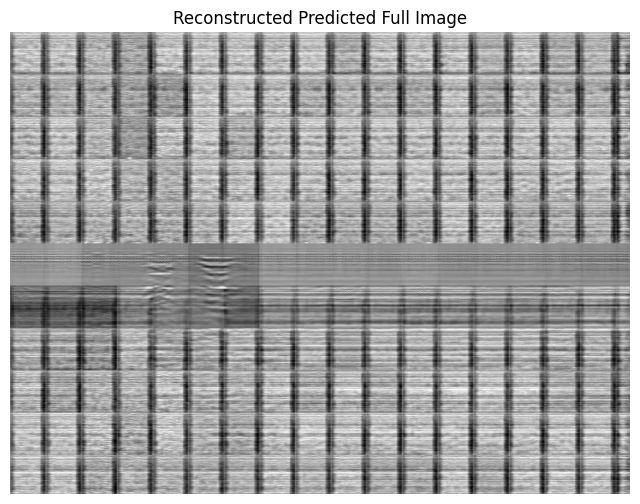

Done.


In [4]:
# predict_and_reconstruct.py
import os
import re
import h5py
import numpy as np
from PIL import Image
import cv2
from math import ceil
import torch
import torch.nn as nn

# -----------------------
# USER CONFIG
# -----------------------
MATFILE    = r"C:\Preet\Real GPR data\two_manholes.mat"                     # your .mat (used for original h,w)
PATCH_DIR  = r"C:\Preet\Real GPR data\patches_global_new1"          # folder containing input patches (row-major patch_000.png ...)
MODEL_PATH = r"C:\Preet\clean_paired_bscans\best_attention_unet_final.pth"  # update path
OUT_DIR    = r"C:\Preet\Real GPR data\attention_unet_with_RB"    # where to save predicted patches + final image
PATCH_SIZE = 256
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (PATCH_SIZE, PATCH_SIZE)  # model input size

os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------
# helper: numerical sort for patch filenames (patch_000.png etc.)
# -----------------------
def numerical_sort(files):
    def num_from_name(f):
        m = re.search(r'(\d+)', os.path.basename(f))
        return int(m.group(1)) if m else -1
    return sorted(files, key=num_from_name)

# -----------------------
# MODEL DEFINITION (copy of your architecture)
# -----------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)

        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# -----------------------
# Load model weights
# -----------------------
model = UNet3WithAttention().to(DEVICE)
state = torch.load(MODEL_PATH, map_location=DEVICE)
# If state is a dict with 'state_dict' key, adapt:
if isinstance(state, dict) and 'state_dict' in state:
    model.load_state_dict(state['state_dict'])
else:
    model.load_state_dict(state)
model.eval()
print("Model loaded on", DEVICE)

# -----------------------
# Get original image dims from .mat file (to compute padding / grid)
# -----------------------
with h5py.File(MATFILE, 'r') as f:
    mat_keys = list(f.keys())
    # use 'mean_trace1' if present else first key
    key = 'mean_trace1' if 'mean_trace1' in mat_keys else mat_keys[0]
    gpr = np.array(f[key])

print("Loaded mat variable shape (original):", gpr.shape)  # example (4453, 2798)
# transpose like earlier pipeline: rows = depth/time, cols = traces
gpr = gpr.T
H, W = gpr.shape
print("Transposed full shape (H, W):", (H, W))

# padded sizes (same logic as creation)
ph = ceil(H / PATCH_SIZE) * PATCH_SIZE
pw = ceil(W / PATCH_SIZE) * PATCH_SIZE
rows = ph // PATCH_SIZE
cols = pw // PATCH_SIZE
print("Padded shape (ph,pw):", (ph,pw), "Grid (rows,cols):", (rows,cols))

# -----------------------
# Load patch files (numerically sorted)
# -----------------------
patch_files = [os.path.join(PATCH_DIR, f) for f in os.listdir(PATCH_DIR) if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))]
patch_files = numerical_sort(patch_files)

if len(patch_files) == 0:
    raise RuntimeError(f"No patch images found in {PATCH_DIR}")

print("Found", len(patch_files), "patch files")

# Validate patch count matches expected grid size (if not, we will still try)
expected = rows * cols
if len(patch_files) != expected:
    print(f"Warning: expected {expected} patches (rows*cols) but found {len(patch_files)}. Script will attempt to place patches row-major into grid using found count.")

# -----------------------
# Inference on patches + save predicted patches
# -----------------------
pred_patch_dir = os.path.join(OUT_DIR, "pred_patches")
os.makedirs(pred_patch_dir, exist_ok=True)

# iterate patches in row-major order
pred_count = 0
for idx, pfile in enumerate(patch_files):
    # load grayscale
    img = Image.open(pfile).convert('L')  # grayscale
    arr = np.array(img).astype(np.float32)

    # Model expects input normalized same as training: reference did /255.0
    inp = arr / 255.0
    inp = torch.from_numpy(inp).unsqueeze(0).unsqueeze(0).to(DEVICE)  # shape (1,1,H,W)

    with torch.no_grad():
        out = model(inp)
    out = out.cpu().numpy().squeeze(0).squeeze(0)  # HxW float

    # Scale to 0-255 and clip
    pred_img = (out * 255.0).clip(0,255).astype(np.uint8)

    # Optional: match contrast (your reference used cv2.normalize)
    pred_img = cv2.normalize(pred_img, None, 0, 255, cv2.NORM_MINMAX)

    # Save predicted patch
    pred_fname = os.path.join(pred_patch_dir, f"pred_{idx:04d}.png")
    Image.fromarray(pred_img).save(pred_fname)
    pred_count += 1

print(f"Saved {pred_count} predicted patches in {pred_patch_dir}")

# -----------------------
# Restitch predicted patches into full image
# -----------------------
full_pred = np.zeros((ph, pw), dtype=np.uint8)

# We place in row-major order; if patch count does not fill grid completely,
# we fill up to available patches.
for idx in range(len(patch_files)):
    r = idx // cols
    c = idx % cols
    pred_fname = os.path.join(pred_patch_dir, f"pred_{idx:04d}.png")
    patch = np.array(Image.open(pred_fname).convert('L'))
    rr = r * PATCH_SIZE
    cc = c * PATCH_SIZE
    full_pred[rr:rr+PATCH_SIZE, cc:cc+PATCH_SIZE] = patch

# Crop back to original size
full_pred = full_pred[:H, :W]

# Save reconstructed full image
out_full_path = os.path.join(OUT_DIR, "reconstructed_pred_full.png")
Image.fromarray(full_pred).save(out_full_path)
print("Saved reconstructed full predicted image:", out_full_path)

# -----------------------
# (Optional) display minimal info
# -----------------------
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,6))
    plt.imshow(full_pred, cmap='gray', aspect='auto')
    plt.title("Reconstructed Predicted Full Image")
    plt.axis('off')
    plt.show()
except Exception:
    pass

print("Done.")


Original full shape (H,W): (2798, 4453)
✅ Saved original full normalized image: C:\Preet\Real GPR data\attention_unet_with_RB\original_full_image.png
Grid rows,cols: 11 18 expected patches: 198
Found patch files: 198
✅ Saved all 198 predicted patches to: C:\Preet\Real GPR data\attention_unet_with_RB\all_predicted_patches
mode=row-major transform=none    -> MSE=191.92
mode=row-major transform=rot90   -> MSE=210.63
mode=row-major transform=rot180  -> MSE=200.43
mode=row-major transform=rot270  -> MSE=210.39
mode=row-major transform=flip_ud -> MSE=202.47
mode=row-major transform=flip_lr -> MSE=208.08
mode=col-major transform=none    -> MSE=211.06
mode=col-major transform=rot90   -> MSE=210.54
mode=col-major transform=rot180  -> MSE=209.44
mode=col-major transform=rot270  -> MSE=210.49
mode=col-major transform=flip_ud -> MSE=209.42
mode=col-major transform=flip_lr -> MSE=210.63

BEST: row-major none MSE= 191.92271
✅ Saved best reconstruction: C:\Preet\Real GPR data\attention_unet_with_RB\b

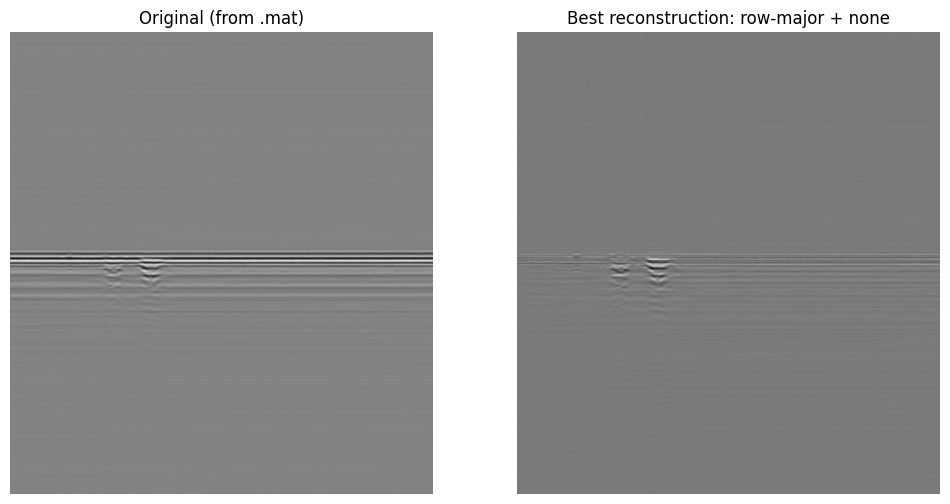

In [8]:
import os, re
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import ceil

# ---------------- USER CONFIG ----------------
MATFILE    = r"C:\Preet\Real GPR data\two_manholes.mat"
PATCH_DIR  = r"C:\Preet\Real GPR data\patches_global_new1"   # folder with predicted patches (or input patches)
OUT_DIR    = r"C:\Preet\Real GPR data\attention_unet_with_RB"
PATCH_SIZE = 256
os.makedirs(OUT_DIR, exist_ok=True)
PATCHES_OUT = os.path.join(OUT_DIR, "all_predicted_patches")
os.makedirs(PATCHES_OUT, exist_ok=True)
# ----------------------------------------------

def numerical_sort(files):
    def num_from_name(f):
        m = re.search(r'(\d+)', os.path.basename(f))
        return int(m.group(1)) if m else -1
    return sorted(files, key=num_from_name)

# load original .mat image (same transpose logic as before)
with h5py.File(MATFILE, 'r') as f:
    key = 'mean_trace1' if 'mean_trace1' in f.keys() else list(f.keys())[0]
    gpr = np.array(f[key])

# transpose to rows=depth, cols=traces
gpr = gpr.T
H, W = gpr.shape
print("Original full shape (H,W):", (H, W))

# normalize original to uint8 0-255 for fair comparison
orig_norm = gpr.astype(np.float32)
orig_norm = (orig_norm - orig_norm.min()) / (orig_norm.max() - orig_norm.min())
orig_uint8 = (orig_norm * 255).astype(np.uint8)

# save original normalized full image (before cropping/padding)
orig_full_path = os.path.join(OUT_DIR, "original_full_image.png")
Image.fromarray(orig_uint8).save(orig_full_path)
print("✅ Saved original full normalized image:", orig_full_path)

# compute padded grid dims (same logic as patching)
ph = ceil(H / PATCH_SIZE) * PATCH_SIZE
pw = ceil(W / PATCH_SIZE) * PATCH_SIZE
rows = ph // PATCH_SIZE
cols = pw // PATCH_SIZE
expected = rows * cols
print("Grid rows,cols:", rows, cols, "expected patches:", expected)

# load patch file list
patch_files = [os.path.join(PATCH_DIR, f) for f in os.listdir(PATCH_DIR)
               if f.lower().endswith(('.png','.jpg','.jpeg','.tif','.bmp'))]
patch_files = numerical_sort(patch_files)
n_patches = len(patch_files)
print("Found patch files:", n_patches)

if n_patches == 0:
    raise RuntimeError("No patch images found in PATCH_DIR")

# read all patches into memory (as uint8 grayscale)
patch_arrays = []
for idx, p in enumerate(patch_files):
    im = Image.open(p).convert('L')
    arr = np.array(im)
    # if patch size mismatches, resize to PATCH_SIZE (safety)
    if arr.shape != (PATCH_SIZE, PATCH_SIZE):
        arr = np.array(im.resize((PATCH_SIZE, PATCH_SIZE)))
    patch_arrays.append(arr.astype(np.uint8))

    # save each patch again in output folder
    patch_out_path = os.path.join(PATCHES_OUT, f"patch_{idx:04d}.png")
    Image.fromarray(arr.astype(np.uint8)).save(patch_out_path)

print(f"✅ Saved all {len(patch_arrays)} predicted patches to:", PATCHES_OUT)

# transformations to try
def apply_transform(patch, t):
    if t == 'none':
        return patch
    if t == 'rot90':
        return np.rot90(patch, k=1)
    if t == 'rot180':
        return np.rot90(patch, k=2)
    if t == 'rot270':
        return np.rot90(patch, k=3)
    if t == 'flip_ud':
        return np.flipud(patch)
    if t == 'flip_lr':
        return np.fliplr(patch)
    return patch

modes = ['row-major', 'col-major']
transforms = ['none','rot90','rot180','rot270','flip_ud','flip_lr']

best = {'mse': float('inf'), 'mode': None, 'transform': None, 'image': None}

def reconstruct_with_mode(patches, mode, transform):
    full = np.zeros((ph, pw), dtype=np.uint8)
    N = len(patches)
    for idx in range(N):
        if mode == 'row-major':
            r = idx // cols
            c = idx % cols
        else:  # col-major
            r = idx % rows
            c = idx // rows
        pr = r * PATCH_SIZE
        pc = c * PATCH_SIZE
        p = apply_transform(patches[idx], transform)
        full[pr:pr+PATCH_SIZE, pc:pc+PATCH_SIZE] = p
    return full

# Try all combinations and evaluate MSE against original (cropped)
for mode in modes:
    for t in transforms:
        full_candidate = reconstruct_with_mode(patch_arrays, mode, t)
        cropped = full_candidate[:H, :W].astype(np.float32)
        if cropped.max() > 255 or cropped.min() < 0:
            cropped = np.clip(cropped, 0, 255)
        mse = np.mean((cropped.astype(np.float32) - orig_uint8.astype(np.float32))**2)
        print(f"mode={mode:9s} transform={t:7s} -> MSE={mse:.2f}")
        if mse < best['mse']:
            best.update({'mse': mse, 'mode': mode, 'transform': t, 'image': cropped.copy()})

print("\nBEST:", best['mode'], best['transform'], "MSE=", best['mse'])

# Save best reconstruction
best_img_uint8 = np.clip(best['image'], 0, 255).astype(np.uint8)
out_best = os.path.join(OUT_DIR, "best_reconstruction_auto.png")
Image.fromarray(best_img_uint8).save(out_best)
print("✅ Saved best reconstruction:", out_best)

# Show original and best side-by-side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(orig_uint8, cmap='gray', aspect='auto')
plt.title("Original (from .mat)")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(best_img_uint8, cmap='gray', aspect='auto')
plt.title(f"Best reconstruction: {best['mode']} + {best['transform']}")
plt.axis('off')
plt.show()


✅ Model loaded on cuda
Original GPR shape (H,W): (2798, 4453)
Grid rows, cols: 11 18
Found 198 patches
✅ Saved all predicted patches
mode=row-major transform=none    -> MSE=2753.61
mode=row-major transform=rot90   -> MSE=2723.38
mode=row-major transform=rot180  -> MSE=2726.74
mode=row-major transform=rot270  -> MSE=2696.37
mode=row-major transform=flip_ud -> MSE=2714.17
mode=row-major transform=flip_lr -> MSE=2763.39
mode=col-major transform=none    -> MSE=2687.21
mode=col-major transform=rot90   -> MSE=2707.15
mode=col-major transform=rot180  -> MSE=2713.95
mode=col-major transform=rot270  -> MSE=2695.89
mode=col-major transform=flip_ud -> MSE=2692.82
mode=col-major transform=flip_lr -> MSE=2708.94

✅ BEST reconstruction: col-major none MSE= 2687.2139


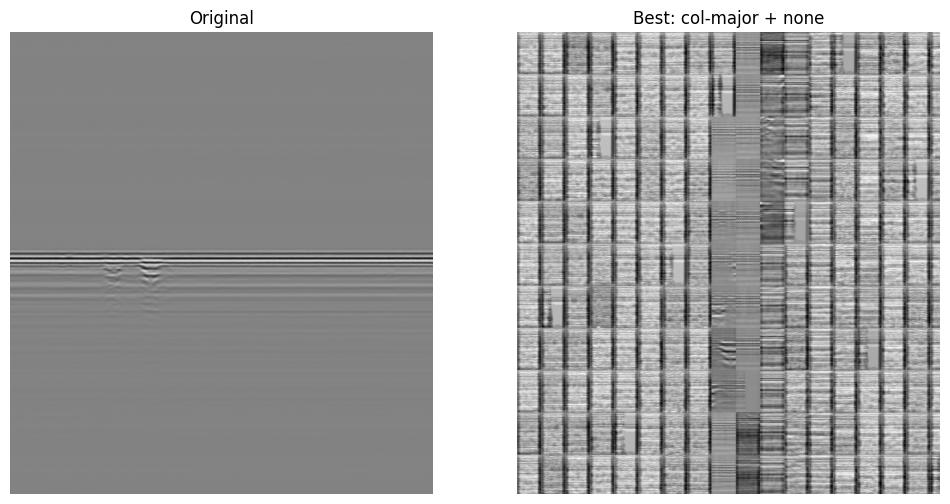

🎉 Done.


In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Predict patches with Attention U-Net + Reconstruct full GPR
===========================================================

Steps:
1. Load trained Attention-UNet with residual blocks.
2. Run inference on all input patches.
3. Save predicted patches.
4. Reconstruct the full image row-major.
5. Try reconstruction variations (row/col-major, flips, rotations).
6. Pick best reconstruction (lowest MSE vs. original .mat GPR).
"""

import os, re
import h5py
import numpy as np
from PIL import Image
import cv2
from math import ceil
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ----------------------- USER CONFIG -----------------------
MATFILE    = r"C:\Preet\Real GPR data\two_manholes.mat"
PATCH_DIR  = r"C:\Preet\Real GPR data\patches_global_new1"
MODEL_PATH = r"C:\Preet\clean_paired_bscans\best_attention_unet_final.pth"
OUT_DIR    = r"C:\Preet\Real GPR data\attention_unet_with_RB"
PATCH_SIZE = 256
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(OUT_DIR, exist_ok=True)
PRED_PATCH_DIR = os.path.join(OUT_DIR, "predicted_patches")
os.makedirs(PRED_PATCH_DIR, exist_ok=True)

# ----------------------- Helper: sort files ----------------
def numerical_sort(files):
    def num_from_name(f):
        m = re.search(r'(\d+)', os.path.basename(f))
        return int(m.group(1)) if m else -1
    return sorted(files, key=num_from_name)

# ----------------------- MODEL DEFINITION ------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x): return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g); x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])
        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(384, 128)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(192, 64)
        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)
        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# ----------------------- Load model ------------------------
model = UNet3WithAttention().to(DEVICE)
state = torch.load(MODEL_PATH, map_location=DEVICE)
if isinstance(state, dict) and 'state_dict' in state:
    model.load_state_dict(state['state_dict'])
else:
    model.load_state_dict(state)
model.eval()
print("✅ Model loaded on", DEVICE)

# ----------------------- Load original .mat ----------------
with h5py.File(MATFILE, 'r') as f:
    key = 'mean_trace1' if 'mean_trace1' in f.keys() else list(f.keys())[0]
    gpr = np.array(f[key])
gpr = gpr.T
H, W = gpr.shape
print("Original GPR shape (H,W):", (H, W))

# normalize original to 0–255
orig_norm = (gpr - gpr.min()) / (gpr.max() - gpr.min())
orig_uint8 = (orig_norm * 255).astype(np.uint8)
Image.fromarray(orig_uint8).save(os.path.join(OUT_DIR, "original_full.png"))

# padded dims
ph = ceil(H / PATCH_SIZE) * PATCH_SIZE
pw = ceil(W / PATCH_SIZE) * PATCH_SIZE
rows, cols = ph // PATCH_SIZE, pw // PATCH_SIZE
print("Grid rows, cols:", rows, cols)

# ----------------------- Load patches ----------------------
patch_files = [os.path.join(PATCH_DIR, f) for f in os.listdir(PATCH_DIR)
               if f.lower().endswith(('.png','.jpg','.jpeg','.tif','.bmp'))]
patch_files = numerical_sort(patch_files)
print("Found", len(patch_files), "patches")

# ----------------------- Inference per patch ----------------
pred_patches = []
for idx, pfile in enumerate(patch_files):
    img = Image.open(pfile).convert('L')
    arr = np.array(img).astype(np.float32)
    inp = torch.from_numpy(arr/255.0).unsqueeze(0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(inp)
    out = out.cpu().numpy().squeeze()
    pred_img = (out * 255.0).clip(0,255).astype(np.uint8)
    pred_img = cv2.normalize(pred_img, None, 0, 255, cv2.NORM_MINMAX)
    pred_patches.append(pred_img)
    Image.fromarray(pred_img).save(os.path.join(PRED_PATCH_DIR, f"pred_{idx:04d}.png"))
print("✅ Saved all predicted patches")

# ----------------------- Reconstruction helpers -------------
def apply_transform(patch, t):
    if t == 'none': return patch
    if t == 'rot90': return np.rot90(patch, 1)
    if t == 'rot180': return np.rot90(patch, 2)
    if t == 'rot270': return np.rot90(patch, 3)
    if t == 'flip_ud': return np.flipud(patch)
    if t == 'flip_lr': return np.fliplr(patch)
    return patch

def reconstruct(patches, mode, transform):
    full = np.zeros((ph, pw), dtype=np.uint8)
    for idx, patch in enumerate(patches):
        if mode == 'row-major':
            r, c = idx // cols, idx % cols
        else: # col-major
            r, c = idx % rows, idx // rows
        rr, cc = r * PATCH_SIZE, c * PATCH_SIZE
        full[rr:rr+PATCH_SIZE, cc:cc+PATCH_SIZE] = apply_transform(patch, transform)
    return full[:H, :W]

# ----------------------- Try all combos ---------------------
modes = ['row-major', 'col-major']
transforms = ['none','rot90','rot180','rot270','flip_ud','flip_lr']
best = {'mse': float('inf'), 'mode': None, 'transform': None, 'image': None}

for mode in modes:
    for t in transforms:
        candidate = reconstruct(pred_patches, mode, t)
        mse = np.mean((candidate.astype(np.float32) - orig_uint8.astype(np.float32))**2)
        print(f"mode={mode:9s} transform={t:7s} -> MSE={mse:.2f}")
        if mse < best['mse']:
            best.update({'mse': mse, 'mode': mode, 'transform': t, 'image': candidate})

# ----------------------- Save best reconstruction -----------
best_img = np.clip(best['image'], 0, 255).astype(np.uint8)
Image.fromarray(best_img).save(os.path.join(OUT_DIR, "best_reconstruction.png"))
print("\n✅ BEST reconstruction:", best['mode'], best['transform'], "MSE=", best['mse'])

# ----------------------- Display side-by-side ---------------
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(orig_uint8, cmap='gray', aspect='auto'); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(best_img, cmap='gray', aspect='auto'); plt.title(f"Best: {best['mode']} + {best['transform']}"); plt.axis('off')
plt.show()

print("🎉 Done.")


In [10]:
import os
import h5py
import cv2
import torch
import numpy as np
from torch import nn
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==========================
# CONFIG
# ==========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

MODEL_PATH = r"C:\Preet\clean_paired_bscans\best_attention_unet_final.pth"
MAT_FILE   = r"C:\Preet\Real GPR data\two_manholes.mat"  # real GPR .mat
PATCHES_DIR = r"C:\Preet\Real GPR data\patches_global_new1"  # already saved patches
OUTPUT_PATCHES = r"C:\Preet\Real GPR data\attention_unet_with_RB\predicted_patches"
OUTPUT_RECON   = r"C:\Preet\Real GPR data\attention_unet_with_RB\real_bscan_reconstructed.png"

TARGET_SIZE = (256, 256)  # must match training

os.makedirs(OUTPUT_PATCHES, exist_ok=True)

# ==========================
# MODEL (same as training)
# ==========================
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x):
        return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(256+256, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(256+128, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(128+64, 64)

        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)
        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# ==========================
# HELPERS
# ==========================
def load_patches(patches_dir):
    patch_files = sorted(glob(os.path.join(patches_dir, "*.png")))
    return patch_files

def preprocess_patch(patch_path):
    img = cv2.imread(patch_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)

def save_pred_patch(pred_tensor, save_path):
    pred = pred_tensor.squeeze().cpu().numpy()
    pred = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
    pred = (pred * 255).astype(np.uint8)
    cv2.imwrite(save_path, pred)

# ==========================
# MAIN
# ==========================
if __name__ == "__main__":
    # Load original .mat just to get dimensions
    with h5py.File(MAT_FILE, 'r') as f:
        gprData = np.array(f['mean_trace1']).T  # (depth, traces)
    H, W = gprData.shape
    print("Original real GPR shape:", gprData.shape)

    # Load model
    model = UNet3WithAttention().to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()

    # Process patches
    patch_files = load_patches(PATCHES_DIR)
    print("Found patches:", len(patch_files))

    patch_size = TARGET_SIZE[0]  # 256
    n_rows = H // patch_size + int(H % patch_size != 0)
    n_cols = W // patch_size + int(W % patch_size != 0)

    recon = np.zeros((n_rows * patch_size, n_cols * patch_size), dtype=np.float32)

    for idx, pf in enumerate(tqdm(patch_files)):
        input_tensor = preprocess_patch(pf).to(DEVICE)
        with torch.no_grad():
            pred = model(input_tensor)
        # save patch
        out_name = os.path.join(OUTPUT_PATCHES, f"pred_{idx:04d}.png")
        save_pred_patch(pred, out_name)

        # reconstruct placement
        row = idx // n_cols
        col = idx % n_cols
        pred_img = pred.squeeze().cpu().numpy()
        recon[row*patch_size:(row+1)*patch_size,
              col*patch_size:(col+1)*patch_size] = pred_img

    # Crop back to original HxW
    recon = recon[:H, :W]
    recon_norm = (recon - recon.min()) / (recon.max() - recon.min() + 1e-8)
    recon_uint8 = (recon_norm * 255).astype(np.uint8)

    cv2.imwrite(OUTPUT_RECON, recon_uint8)
    print(f"✅ Saved reconstructed image: {OUTPUT_RECON}")
    print(f"✅ Saved predicted patches in {OUTPUT_PATCHES}")


Running on: cuda
Original real GPR shape: (2798, 4453)
Found patches: 198


100%|██████████| 198/198 [00:01<00:00, 165.62it/s]


✅ Saved reconstructed image: C:\Preet\Real GPR data\attention_unet_with_RB\real_bscan_reconstructed.png
✅ Saved predicted patches in C:\Preet\Real GPR data\attention_unet_with_RB\predicted_patches


In [1]:
import os
import cv2
import torch
import numpy as np
from torch import nn

# ==========================
# CONFIG (paths edited)
# ==========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

MODEL_PATH   = r"C:\Preet\clean_paired_bscans\best_attention_unet_final.pth"
IMAGE_DIR    = r"C:\Preet\Real GPR data"  # where the two PNGs live
INPUT_IMAGES = [
    os.path.join(IMAGE_DIR, "cropped_patch_256x256.png"),
]
OUTPUT_DIR   = r"C:\Preet\Real GPR data\attention_unet_with_RB\single_image_preds"
TARGET_SIZE  = (256, 256)  # H, W used by the model

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ==========================
# MODEL (same as training)
# ==========================
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x):
        return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])
        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(256+256, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(256+128, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(128+64, 64)

        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b  = self.bottleneck(p3)
        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# ==========================
# HELPERS
# ==========================
def preprocess(img_path, target_hw=(256, 256)):
    """Load grayscale, ensure 256x256, normalize to [0,1], -> (1,1,H,W) tensor."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    if img.shape != target_hw:
        img = cv2.resize(img, (target_hw[1], target_hw[0]), interpolation=cv2.INTER_CUBIC)
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    return tensor

def save_pred(pred_tensor, save_path):
    pred = pred_tensor.squeeze().cpu().numpy()
    pred = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
    pred = (pred * 255).astype(np.uint8)
    cv2.imwrite(save_path, pred)

# ==========================
# MAIN
# ==========================
if __name__ == "__main__":
    # Load model
    model = UNet3WithAttention().to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Model loaded:", MODEL_PATH)

    for img_path in INPUT_IMAGES:
        name = os.path.splitext(os.path.basename(img_path))[0]
        out_path = os.path.join(OUTPUT_DIR, f"{name}_pred_256x256.png")

        x = preprocess(img_path, TARGET_SIZE).to(DEVICE)
        with torch.no_grad():
            y = model(x)

        save_pred(y, out_path)
        print(f"✅ Saved prediction for {name}: {out_path}")


Running on: cuda
Model loaded: C:\Preet\clean_paired_bscans\best_attention_unet_final.pth
✅ Saved prediction for cropped_patch_256x256: C:\Preet\Real GPR data\attention_unet_with_RB\single_image_preds\cropped_patch_256x256_pred_256x256.png


--------------------------------

------------------

----------------------

-----------------------

training on 400-670 Mhz dataset - size of dataset -> 3404 images -> approx -> 3400 paired images -> 1700 images

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# ==========================
# CONFIG
# ==========================
DATASET_DIR = r"C:\Preet\png_images_400M_670M"  # both *_l.png and *_h.png are here
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 75
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

MODEL_PATH = os.path.join(DATASET_DIR, "best_attention_unet_final.pth")
RESULTS_DIR = os.path.join(DATASET_DIR, "predictions_attention_final")
os.makedirs(RESULTS_DIR, exist_ok=True)

# ==========================
# DATASET
# ==========================
class GPRDataset(Dataset):
    def __init__(self, x_paths, y_paths):
        self.x_paths = x_paths
        self.y_paths = y_paths

    def __len__(self):
        return len(self.x_paths)

    def __getitem__(self, idx):
        x = np.array(Image.open(self.x_paths[idx]).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        y = np.array(Image.open(self.y_paths[idx]).resize(IMAGE_SIZE), dtype=np.float32) / 255.0
        x = torch.tensor(x).unsqueeze(0)  # (1,H,W)
        y = torch.tensor(y).unsqueeze(0)
        return x, y

def load_data(dataset_dir):
    low_paths, high_paths = [], []
    for file in os.listdir(dataset_dir):
        if file.endswith("_l.png"):
            low_path = os.path.join(dataset_dir, file)
            high_path = os.path.join(dataset_dir, file.replace("_l.png", "_h.png"))
            if os.path.exists(high_path):
                low_paths.append(low_path)
                high_paths.append(high_path)
    return low_paths, high_paths


# ==========================
# DATA SPLIT (80:20 Train/Test)
# ==========================
all_x, all_y = load_data(DATASET_DIR)

train_x, test_x, train_y, test_y = train_test_split(
    all_x, all_y, test_size=0.20, random_state=42
)

print(f"Train: {len(train_x)}, Test: {len(test_x)}")

train_loader = DataLoader(GPRDataset(train_x, train_y), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(GPRDataset(test_x, test_y), batch_size=1, shuffle=False)


# ==========================
# MODEL BLOCKS
# ==========================
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x):
        return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

# ==========================
# UNet-3 with Attention + Residual Bottleneck
# ==========================
class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (3 levels)
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)

        # Bottleneck with residual blocks (FIX: 256 channels)
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)   # bottleneck=256, skip=256
        self.dec3 = ConvBlock(256+256, 256)        # concat → 512

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(256+128, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(128+64, 64)

        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))

        return self.out_conv(d1)


# ==========================
# TRAINING
# ==========================
model = UNet3WithAttention().to(DEVICE)
criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_train_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.6f}")

    # Save best model based on training loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  ✅ Saved Best Model at Epoch {epoch+1}")


# ==========================
# INFERENCE
# ==========================
print("\nRunning inference on test set...")
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

for i, (x, y) in enumerate(test_loader):
    x = x.to(DEVICE)
    with torch.no_grad():
        pred = model(x).cpu().squeeze(0).squeeze(0).numpy()
    pred_img = (pred * 255.0).clip(0, 255).astype(np.uint8)
    Image.fromarray(pred_img).save(os.path.join(RESULTS_DIR, f"pred_{i+1}.png"))

print(f"Predictions saved in {RESULTS_DIR}")

Running on: cuda
Train: 1361, Test: 341
Epoch [1/75] Train Loss: 0.023894
  ✅ Saved Best Model at Epoch 1
Epoch [2/75] Train Loss: 0.000368
  ✅ Saved Best Model at Epoch 2
Epoch [3/75] Train Loss: 0.000275
  ✅ Saved Best Model at Epoch 3
Epoch [4/75] Train Loss: 0.000215
  ✅ Saved Best Model at Epoch 4
Epoch [5/75] Train Loss: 0.000159
  ✅ Saved Best Model at Epoch 5
Epoch [6/75] Train Loss: 0.000134
  ✅ Saved Best Model at Epoch 6
Epoch [7/75] Train Loss: 0.000101
  ✅ Saved Best Model at Epoch 7
Epoch [8/75] Train Loss: 0.000086
  ✅ Saved Best Model at Epoch 8
Epoch [9/75] Train Loss: 0.000071
  ✅ Saved Best Model at Epoch 9
Epoch [10/75] Train Loss: 0.000066
  ✅ Saved Best Model at Epoch 10
Epoch [11/75] Train Loss: 0.000068
Epoch [12/75] Train Loss: 0.000053
  ✅ Saved Best Model at Epoch 12
Epoch [13/75] Train Loss: 0.000053
Epoch [14/75] Train Loss: 0.000047
  ✅ Saved Best Model at Epoch 14
Epoch [15/75] Train Loss: 0.000049
Epoch [16/75] Train Loss: 0.000061
Epoch [17/75] Train Lo

In [2]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from math import log10


import shutil
os.makedirs(r"C:\Preet\png_images_400M_670M\ground_truth_test_final", exist_ok=True)

for f in test_y:  # list of test high-res paths from your train/val/test split
    shutil.copy(f, r"C:\Preet\png_images_400M_670M\ground_truth_test_final")


# ==== PATHS ====
pred_dir = r"C:\Preet\png_images_400M_670M\predictions_attention_final"
gt_dir   = r"C:\Preet\png_images_400M_670M\ground_truth_test_final"

# ==== FUNCTIONS ====
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=255)

# ==== MAIN ====
psnr_values, ssim_values = [], []

pred_files = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
gt_files   = sorted([f for f in os.listdir(gt_dir)   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

num_pairs = min(len(pred_files), len(gt_files))
if num_pairs == 0:
    print("[Error] No matching image files found in both directories.")
else:
    if len(pred_files) != len(gt_files):
        print(f"[Warning] Different number of images: Predictions={len(pred_files)}, Ground Truth={len(gt_files)}")
        print(f"Evaluating only first {num_pairs} matched pairs.")

    for i in range(num_pairs):
        pred_path = os.path.join(pred_dir, pred_files[i])
        gt_path   = os.path.join(gt_dir, gt_files[i])

        pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
        gt_img   = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        if pred_img is None or gt_img is None:
            print(f"[Error] Could not load: {pred_files[i]} or {gt_files[i]}")
            continue

        if pred_img.shape != gt_img.shape:
            pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]))

        psnr_values.append(calculate_psnr(pred_img, gt_img))
        ssim_values.append(calculate_ssim(pred_img, gt_img))

    if psnr_values and ssim_values:
        print(f"\n---- Test Set Evaluation ----")
        print(f"SSIM: avg={np.mean(ssim_values):.4f}, min={np.min(ssim_values):.4f}, max={np.max(ssim_values):.4f}")
        print(f"PSNR: avg={np.mean(psnr_values):.2f} dB, min={np.min(psnr_values):.2f} dB, max={np.max(psnr_values):.2f} dB")


---- Test Set Evaluation ----
SSIM: avg=0.9185, min=0.7815, max=0.9975
PSNR: avg=35.66 dB, min=30.19 dB, max=48.98 dB


In [3]:
# testing real gpr data from mendaley's
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F

# ==========================
# CONFIG
# ==========================
REAL_DATA_DIR = r"C:\Preet\Real GPR data\mendaley\Utilities_resized"
MODEL_PATH = r"C:\Preet\png_images_400M_670M\best_attention_unet_final.pth"
RESULTS_DIR = r"C:\Preet\Real GPR data\mendaley\Utilities_predictions"
os.makedirs(RESULTS_DIR, exist_ok=True)

IMAGE_SIZE = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

# ==========================
# MODEL (same as training)
# ==========================
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    def forward(self, x):
        return x + self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi

class UNet3WithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(1, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256); self.pool3 = nn.MaxPool2d(2)
        self.bottleneck = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(256+256, 256)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionGate(256, 128, 64)
        self.dec2 = ConvBlock(256+128, 128)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionGate(128, 64, 32)
        self.dec1 = ConvBlock(128+64, 64)
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        b = self.bottleneck(p3)
        u3 = self.up3(b); a3 = self.att3(c3, u3); d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3); a2 = self.att2(c2, u2); d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2); a1 = self.att1(c1, u1); d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.out_conv(d1)

# ==========================
# LOAD MODEL
# ==========================
model = UNet3WithAttention().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ==========================
# INFERENCE ON REAL DATA
# ==========================
files = [f for f in os.listdir(REAL_DATA_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for i, fname in enumerate(sorted(files)):
    img_path = os.path.join(REAL_DATA_DIR, fname)

    # Load and preprocess
    img = Image.open(img_path).convert("L").resize(IMAGE_SIZE)
    arr = np.array(img, dtype=np.float32) / 255.0
    tensor = torch.tensor(arr).unsqueeze(0).unsqueeze(0).to(DEVICE)  # (1,1,H,W)

    # Run inference
    with torch.no_grad():
        pred = model(tensor).cpu().squeeze(0).squeeze(0).numpy()

    # Save prediction
    pred_img = (pred * 255.0).clip(0, 255).astype(np.uint8)
    out_path = os.path.join(RESULTS_DIR, f"pred_{i+1}.png")
    Image.fromarray(pred_img).save(out_path)
    print(f"Saved: {out_path}")

print(f"\n✅ Predictions saved in {RESULTS_DIR}")


Running on: cuda
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_1.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_2.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_3.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_4.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_5.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_6.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_7.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_8.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_9.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_10.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_11.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_12.png
Saved: C:\Preet\Real GPR data\mendaley\Utilities_predictions\pred_13.png
Saved: C:\Preet\Real GPR data\mendaley\Util